In [1]:
import cobra
import pandas as pd
from util.manipulation import load_latest_model
import numpy as np
import matplotlib.pyplot as plt

### Tutorial 1: General manipulations

This tutorial covers the general manipulations that can performed on the *i*JL208 model. The following basic manipulations are executed:

    1- Load the latest version of the model and display the number of reactions, genes and metabolites
    2- Get the optimal solution and growth rate prediction
    3- Get and display a predicted flux state, the number of used reactions
    4- Formulate a single gene essentiality prediction
    5- Using parsimonious FBA (pFBA) for results more similar to expression data

In [2]:
#Use the util function to load the latest model from the model_versions folder
model = load_latest_model()

In [5]:
#Display the number of reactions, genes and metabolites in the model
print(f"The {model.name} model contains {len(model.reactions)} reactions, {len(model.genes)} genes and {len(model.metabolites)} metabolites")

The iJL208 with inactive CHTNDAe model contains 364 reactions, 207 genes and 348 metabolites


In [6]:
#Get the predicted growth rate and validate that the model solves correctly
solution = model.optimize()
if solution.status == 'optimal':
    print(f"The {model.name} has an optimal solution and the predicted growth rate is: {solution.objective_value}")
else:
    raise ValueError(f"The model does not have an optimal solution, ensure the )

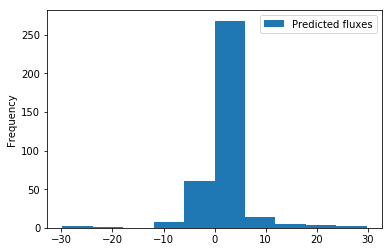

In [11]:
#Plot the predicted flux state
predicted_fluxes = pd.DataFrame({'Predicted fluxes':solution.fluxes.to_list()},index=solution.fluxes.index.to_list())
predicted_fluxes.plot(kind='hist')

In [14]:
#Get the number of used/unused reactions, those are the reactions for which no flux is predicted
used_reactions = predicted_fluxes[predicted_fluxes['Predicted fluxes']!=0]
unused_reactions = predicted_fluxes[predicted_fluxes['Predicted fluxes']==0]
print(f"The model has {len(used_reactions)} used reactions and {len(unused_reactions)} unused reactions")

The model has 217 used reactions and 147 unused reactions


In [16]:
#Formulate a single gene essentiality prediction
from cobra.flux_analysis import single_gene_deletion
single_gene_essentiality_prediction = single_gene_deletion(model)

In [40]:
#Get the list of essential gene
#Define a threshold for essential as 50% of the original growth rate
essentiality_threshold = solution.objective_value * 0.5
#Essential genes have a predicted growth rate inferior or equal to the threshold or NaN
essential_genes = [list(g)[0] for g in single_gene_essentiality_prediction[(single_gene_essentiality_prediction['growth']<=essentiality_threshold)\
                                                                          |(single_gene_essentiality_prediction['growth'].isna())].index]
#Non essential genes have a predicted growth rate higher than threshold
non_essential_genes = [list(g)[0] for g in single_gene_essentiality_prediction[single_gene_essentiality_prediction['growth']> essentiality_threshold].index]

In [42]:
#Display the number of essential and non essential genes
print(f"The model has {len(essential_genes)} essential genes and {len(non_essential_genes)} non essentials")

The model has 97 essential genes and 110 non essentials


In [43]:
#Optimize the model using pFBA
from cobra.flux_analysis import pfba

In [44]:
#Generate the pFBA solution
pfba_solution = pfba(model)
#This solution contains the same elements as a regular FBA solution 
#--> objective_value, fluxes, shadow_prices, reduced_costs and status

In [49]:
#Now compare the two flux predictions
#Plot the predicted flux state
pfba_predicted_fluxes = pd.DataFrame({'pFBA predicted fluxes':pfba_solution.fluxes.to_list()},index=pfba_solution.fluxes.index.to_list())

Text(0, 0.5, 'pFBA')

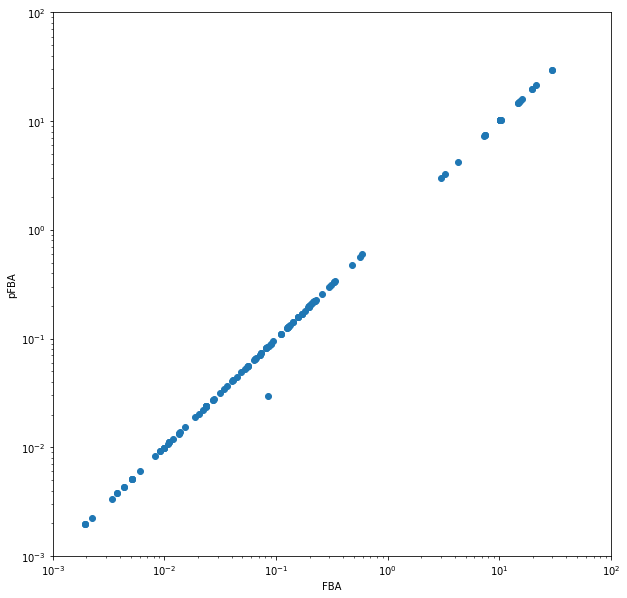

In [82]:
#Compare the two flux distributions 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
x = predicted_fluxes['Predicted fluxes'].tolist()
y = pfba_predicted_fluxes['pFBA predicted fluxes'].tolist()
ax.scatter(x=x,y=y)

#Display on log scale
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-3,1e2)
ax.set_ylim(1e-3,1e2)
ax.set_xlabel('FBA')
ax.set_ylabel('pFBA')

In [89]:
#Get the flux predictions difference
all_fluxes = pd.concat([predicted_fluxes,pfba_predicted_fluxes],axis=1,sort=True)
all_fluxes['difference'] = all_fluxes['pFBA predicted fluxes'] - all_fluxes['Predicted fluxes']
#Display
all_fluxes[all_fluxes['difference']>1e-9]

,Predicted fluxes,pFBA predicted fluxes,difference
EX_gly_met__L_e,-0.054765,0.000000,0.054765
EX_h2o_e,-4.303542,-4.248777,0.054765
METabc,0.000000,0.054765,0.054765


#### End of the first tutorial

In this tutorial, only static observations of the model were performed and slighlty compared to one another. In Tutorial 2, we will apply modifications to the model, generate and compare new predictions resulting from these modifications. 